In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers biopython kaggle
print("✅ Đã cài đặt xong thư viện!")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.2 MB/s eta 0:00:00
✅ Đã cài đặt xong thư viện!


In [2]:
import os
from google.colab import files

# Upload file kaggle.json
print("Vui lòng upload file kaggle.json của bạn:")
files.upload()

# Cấu hình Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Vui lòng upload file kaggle.json của bạn:


Saving kaggle.json to kaggle.json


In [3]:
# Tải dữ liệu cuộc thi (Sẽ mất khoảng 1-2 phút)
print("⏳ Đang tải dữ liệu CAFA 6...")
!kaggle competitions download -c cafa-6-protein-function-prediction
!unzip -q cafa-6-protein-function-prediction.zip -d /content/cafa6_data
print("✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data")

⏳ Đang tải dữ liệu CAFA 6...
  0% 0.00/91.2M [00:00<?, ?B/s]
100% 91.2M/91.2M [00:00<00:00, 1.29GB/s]
✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data


⏳ Đang tải dữ liệu...
⏳ Đang tính toán Score...

📊 BẢNG PHÂN TÍCH ĐIỂM CẮT (CUTOFF POINTS)
TOP K      | Score Tích Lũy (%)   | Min Freq   | Min Score 
------------------------------------------------------------
1000       | 57.60%              | 21         | 122.58
3000       | 76.77%              | 9          | 43.77
5000       | 85.60%              | 20         | 24.74
8000       | 92.87%              | 26         | 12.82
10000      | 95.69%              | 13         | 8.48
15000      | 99.24%              | 24         | 2.66
20000      | 100.00%              | 1          | 0.00


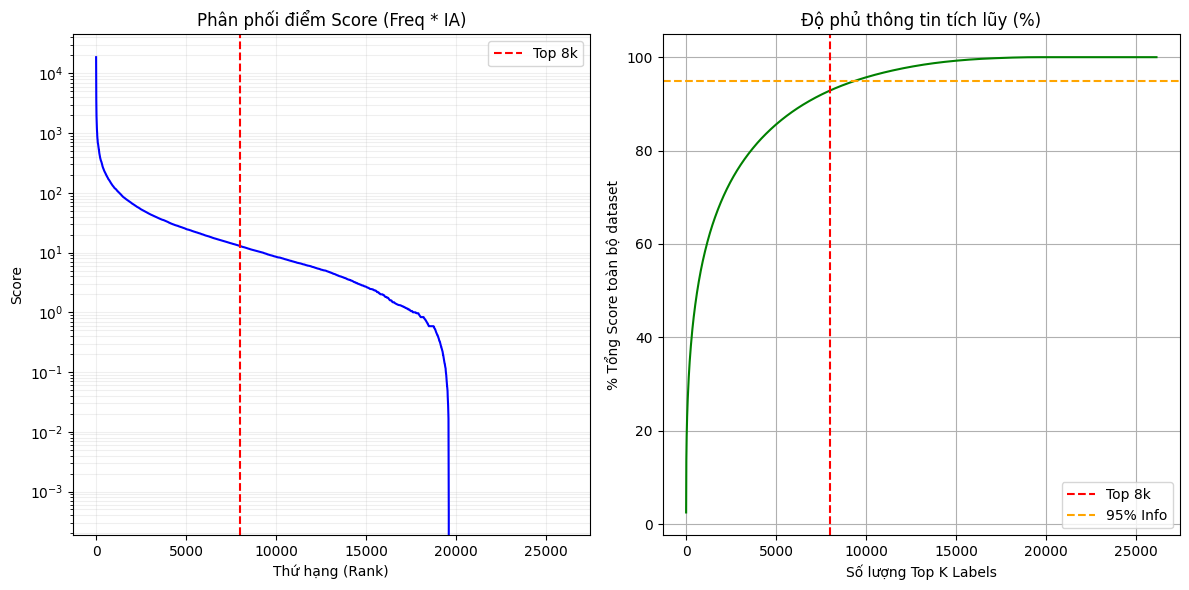


💡 LỜI KHUYÊN:
- Hãy chọn K sao cho đường màu xanh lá (Biểu đồ 2) bắt đầu đi ngang (bão hòa).
- Thường thì Top 5000 - 8000 là đủ để phủ >90% thông tin quan trọng.
- Nếu Top 20k mà Min Freq < 10, thì đó là vùng nhiễu (noise), không nên học.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIG =================
TRAIN_TERMS_PATH = '/content/cafa6_data/Train/train_terms.tsv'
IA_PATH = '/content/cafa6_data/IA.tsv'
# ==========================================

print("⏳ Đang tải dữ liệu...")

# 1. Load Data
df_terms = pd.read_csv(TRAIN_TERMS_PATH, sep='\t', header=0, names=['EntryID', 'term', 'aspect'])
df_ia = pd.read_csv(IA_PATH, sep='\t', names=['term', 'ia'])
ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

# 2. Tính toán Score = Freq * IA
print("⏳ Đang tính toán Score...")
term_counts = df_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'freq']
term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)
term_counts['score'] = term_counts['freq'] * term_counts['ia']

# 3. Sắp xếp giảm dần
df_metrics = term_counts.sort_values(by='score', ascending=False).reset_index(drop=True)

# 4. Tính phần trăm tích lũy (Cumulative Percentage)
total_score = df_metrics['score'].sum()
df_metrics['cumulative_score'] = df_metrics['score'].cumsum()
df_metrics['cumulative_percent'] = (df_metrics['cumulative_score'] / total_score) * 100

# ================= HIỂN THỊ THỐNG KÊ =================
print("\n" + "="*50)
print("📊 BẢNG PHÂN TÍCH ĐIỂM CẮT (CUTOFF POINTS)")
print("="*50)

# Các mốc quan trọng để bạn quyết định Top-K
cutoffs = [1000, 3000, 5000, 8000, 10000, 15000, 20000]

print(f"{'TOP K':<10} | {'Score Tích Lũy (%)':<20} | {'Min Freq':<10} | {'Min Score':<10}")
print("-" * 60)

for k in cutoffs:
    if k < len(df_metrics):
        row = df_metrics.iloc[k-1]
        print(f"{k:<10} | {row['cumulative_percent']:.2f}%{' '*13} | {row['freq']:<10} | {row['score']:.2f}")

# ================= VẼ BIỂU ĐỒ =================
plt.figure(figsize=(12, 6))

# Biểu đồ 1: Score giảm dần
plt.subplot(1, 2, 1)
plt.plot(df_metrics.index, df_metrics['score'], color='blue')
plt.title('Phân phối điểm Score (Freq * IA)')
plt.xlabel('Thứ hạng (Rank)')
plt.ylabel('Score')
plt.yscale('log') # Dùng thang log để dễ nhìn phần đuôi
plt.grid(True, which="both", ls="-", alpha=0.2)
# Vẽ đường cắt tại Top 8000
plt.axvline(x=8000, color='red', linestyle='--', label='Top 8k')
plt.legend()

# Biểu đồ 2: Tích lũy thông tin
plt.subplot(1, 2, 2)
plt.plot(df_metrics.index, df_metrics['cumulative_percent'], color='green')
plt.title('Độ phủ thông tin tích lũy (%)')
plt.xlabel('Số lượng Top K Labels')
plt.ylabel('% Tổng Score toàn bộ dataset')
plt.grid(True)
plt.axvline(x=8000, color='red', linestyle='--', label='Top 8k')
plt.axhline(y=95, color='orange', linestyle='--', label='95% Info')
plt.legend()

plt.tight_layout()
plt.show()

print("\n💡 LỜI KHUYÊN:")
print("- Hãy chọn K sao cho đường màu xanh lá (Biểu đồ 2) bắt đầu đi ngang (bão hòa).")
print("- Thường thì Top 5000 - 8000 là đủ để phủ >90% thông tin quan trọng.")
print("- Nếu Top 20k mà Min Freq < 10, thì đó là vùng nhiễu (noise), không nên học.")

In [7]:
import pandas as pd
import numpy as np

# ================= CONFIG =================
TRAIN_TERMS_PATH = '/content/cafa6_data/Train/train_terms.tsv'
IA_PATH = '/content/cafa6_data/IA.tsv'
# ==========================================

print("⏳ Đang tải và xử lý dữ liệu...")

# 1. Load Data
df_terms = pd.read_csv(TRAIN_TERMS_PATH, sep='\t', header=0, names=['EntryID', 'term', 'aspect'])
df_ia = pd.read_csv(IA_PATH, sep='\t', names=['term', 'ia'])
ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

# 2. Tính toán Score = Freq * IA
term_counts = df_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'freq']
term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)
term_counts['score'] = term_counts['freq'] * term_counts['ia']

# 3. Sắp xếp giảm dần theo Score
df_metrics = term_counts.sort_values(by='score', ascending=False).reset_index(drop=True)

# 4. Tính các chỉ số tích lũy (CUMULATIVE METRICS)
total_score = df_metrics['score'].sum()
df_metrics['cumulative_score'] = df_metrics['score'].cumsum()
df_metrics['cumulative_percent'] = (df_metrics['cumulative_score'] / total_score) * 100

# --- SỬA ĐỔI QUAN TRỌNG TẠI ĐÂY ---
# Tính Min Freq tích lũy: Tại dòng i, nó là min(freq[0]...freq[i])
df_metrics['running_min_freq'] = df_metrics['freq'].cummin()

# ================= HIỂN THỊ THỐNG KÊ =================
print("\n" + "="*60)
print("📊 BẢNG PHÂN TÍCH ĐIỂM CẮT (ĐÃ FIX LOGIC MIN)")
print("="*60)

cutoffs = [1000, 3000, 5000, 8000, 10000, 15000, 20000]

print(f"{'TOP K':<10} | {'Score Tích Lũy':<15} | {'Real Min Freq':<15} | {'Biên Freq (K-th)':<15}")
print("-" * 70)

for k in cutoffs:
    if k <= len(df_metrics):
        row = df_metrics.iloc[k-1]

        # running_min_freq: Là số nhỏ nhất trong toàn bộ k phần tử đầu tiên
        real_min = row['running_min_freq']

        # freq: Là tần suất của thằng đứng thứ k (để tham khảo)
        border_freq = row['freq']

        print(f"{k:<10} | {row['cumulative_percent']:.2f}%{' '*9} | {real_min:<15} | {border_freq:<15}")

print("\n💡 NHẬN XÉT:")
print("Nếu cột 'Real Min Freq' là 1 hoặc một số rất nhỏ ngay từ các Top đầu,")
print("điều đó CHỨNG MINH rằng các Top K đang bị lẫn các nhãn RẤT HIẾM (nhưng IA cao).")
print("👉 BẮT BUỘC PHẢI DÙNG 'HARD FILTER' (Lọc freq >= 50) TRƯỚC KHI SORT SCORE.")

⏳ Đang tải và xử lý dữ liệu...

📊 BẢNG PHÂN TÍCH ĐIỂM CẮT (ĐÃ FIX LOGIC MIN)
TOP K      | Score Tích Lũy  | Real Min Freq   | Biên Freq (K-th)
----------------------------------------------------------------------
1000       | 57.60%          | 11              | 21             
3000       | 76.77%          | 4               | 9              
5000       | 85.60%          | 2               | 20             
8000       | 92.87%          | 1               | 26             
10000      | 95.69%          | 1               | 13             
15000      | 99.24%          | 1               | 24             
20000      | 100.00%          | 1               | 1              

💡 NHẬN XÉT:
Nếu cột 'Real Min Freq' là 1 hoặc một số rất nhỏ ngay từ các Top đầu,
điều đó CHỨNG MINH rằng các Top K đang bị lẫn các nhãn RẤT HIẾM (nhưng IA cao).
👉 BẮT BUỘC PHẢI DÙNG 'HARD FILTER' (Lọc freq >= 50) TRƯỚC KHI SORT SCORE.


⏳ Đang xử lý dữ liệu...


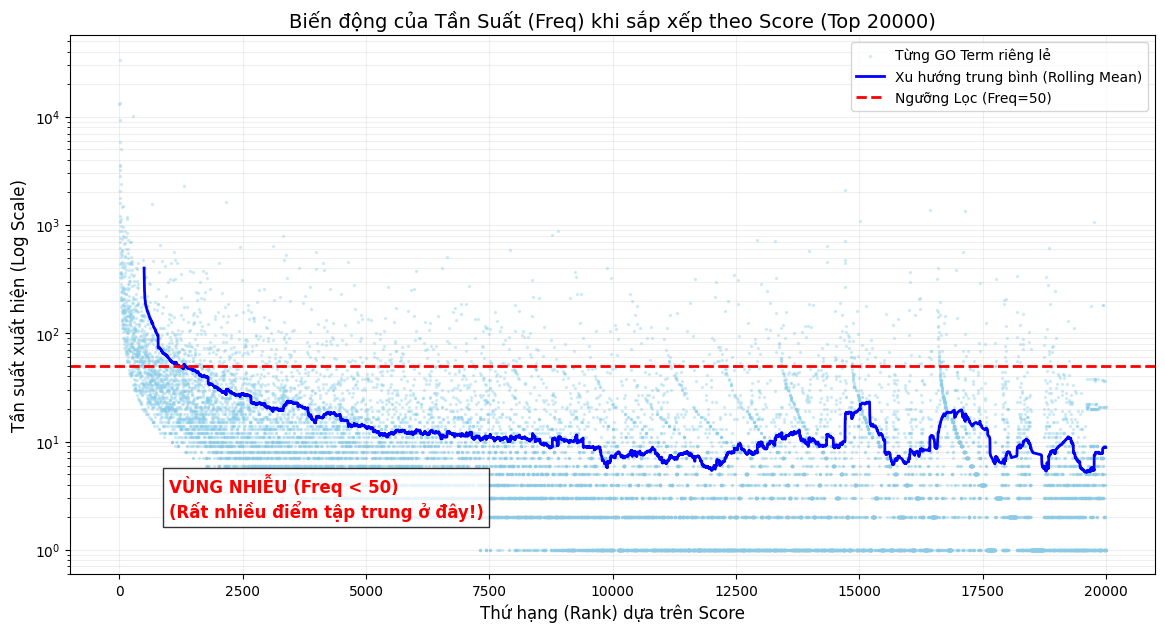

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIG =================
TRAIN_TERMS_PATH = '/content/cafa6_data/Train/train_terms.tsv'
IA_PATH = '/content/cafa6_data/IA.tsv'
TOP_K_VIEW = 20000 # Chỉ vẽ 20k thằng đầu tiên để soi kỹ
# ==========================================

print("⏳ Đang xử lý dữ liệu...")

# 1. Load và Tính Score
df_terms = pd.read_csv(TRAIN_TERMS_PATH, sep='\t', header=0, names=['EntryID', 'term', 'aspect'])
df_ia = pd.read_csv(IA_PATH, sep='\t', names=['term', 'ia'])
ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

term_counts = df_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'freq']
term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)
term_counts['score'] = term_counts['freq'] * term_counts['ia']

# 2. Sắp xếp theo SCORE (Giảm dần)
df_sorted = term_counts.sort_values(by='score', ascending=False).reset_index(drop=True)

# Lấy Top K để vẽ
df_view = df_sorted.head(TOP_K_VIEW).copy()
df_view['rank'] = df_view.index + 1

# 3. Tính đường trung bình trượt (Moving Average) để thấy xu hướng rõ hơn
# (Làm mượt dao động để thấy trend chính)
df_view['rolling_freq'] = df_view['freq'].rolling(window=500).mean()

# ================= VẼ BIỂU ĐỒ =================
plt.figure(figsize=(14, 7))

# Vẽ từng điểm (Scatter)
plt.scatter(df_view['rank'], df_view['freq'],
            alpha=0.3, s=2, color='skyblue', label='Từng GO Term riêng lẻ')

# Vẽ đường trung bình (Trend)
plt.plot(df_view['rank'], df_view['rolling_freq'],
         color='blue', linewidth=2, label='Xu hướng trung bình (Rolling Mean)')

# Vẽ đường giới hạn Freq = 50 (Vùng an toàn)
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Ngưỡng Lọc (Freq=50)')

# Trang trí
plt.yscale('log') # QUAN TRỌNG: Dùng thang log vì freq chênh lệch rất lớn
plt.title(f'Biến động của Tần Suất (Freq) khi sắp xếp theo Score (Top {TOP_K_VIEW})', fontsize=14)
plt.xlabel('Thứ hạng (Rank) dựa trên Score', fontsize=12)
plt.ylabel('Tần suất xuất hiện (Log Scale)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Chú thích vùng nguy hiểm
plt.text(1000, 2, 'VÙNG NHIỄU (Freq < 50)\n(Rất nhiều điểm tập trung ở đây!)',
         color='red', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [9]:
import pandas as pd
import numpy as np

# ================= CONFIG =================
TRAIN_TERMS_PATH = '/content/cafa6_data/Train/train_terms.tsv'
IA_PATH = '/content/cafa6_data/IA.tsv'
# ==========================================

print("⏳ Đang xử lý dữ liệu...")

# 1. Load và Tính Score
df_terms = pd.read_csv(TRAIN_TERMS_PATH, sep='\t', header=0, names=['EntryID', 'term', 'aspect'])
df_ia = pd.read_csv(IA_PATH, sep='\t', names=['term', 'ia'])
ia_dict = dict(zip(df_ia['term'], df_ia['ia']))

term_counts = df_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'freq']
term_counts['ia'] = term_counts['term'].map(ia_dict).fillna(0.0)
term_counts['score'] = term_counts['freq'] * term_counts['ia']

# 2. Sắp xếp theo SCORE (Giảm dần) - Đây là cách bạn đang chọn Top K hiện tại
df_sorted = term_counts.sort_values(by='score', ascending=False).reset_index(drop=True)

# ================= THỐNG KÊ =================
print("\n" + "="*80)
print("📊 BẢNG THỐNG KÊ 'RÁC' (SỐ LƯỢNG NHÃN HIẾM) TRONG CÁC TOP K")
print("="*80)
print("Dữ liệu hiển thị dạng: Số lượng (Tỷ lệ % trong Top K)")
print("-" * 80)

# Các mốc Top K cần kiểm tra
k_milestones = [1000, 3000, 5000, 8000, 10000, 15000, 20000]
# Các ngưỡng tần suất "nguy hiểm"
freq_checks = [1, 2, 5, 10, 20, 50]

# Tạo tiêu đề bảng
header = f"{'TOP K':<10}"
for f in freq_checks:
    header += f" | {'<= ' + str(f):<12}"
print(header)
print("-" * 80)

for k in k_milestones:
    # Lấy Top K dòng đầu tiên
    subset = df_sorted.head(k)

    row_str = f"{k:<10}"

    for f in freq_checks:
        # Đếm số lượng nhãn có freq <= f trong tập subset này
        count = len(subset[subset['freq'] <= f])
        percent = (count / k) * 100

        # Format màu mè chút để dễ nhìn
        val_str = f"{count} ({percent:.0f}%)"
        row_str += f" | {val_str:<12}"

    print(row_str)

print("-" * 80)
print("\n💡 CÁCH ĐỌC KẾT QUẢ:")
print("1. Cột '<= 1': Số lượng nhãn chỉ xuất hiện ĐÚNG 1 LẦN trong tập train.")
print("   -> Nếu cột này > 0 ở Top đầu, chứng tỏ Score đã đưa nhãn rác lên top.")
print("2. Cột '<= 50': Đây là ngưỡng lọc chúng ta dự định dùng.")
print("   -> Nếu tỷ lệ này cao (ví dụ 30%), tức là 30% Top K của bạn là nhãn khó học.")

⏳ Đang xử lý dữ liệu...

📊 BẢNG THỐNG KÊ 'RÁC' (SỐ LƯỢNG NHÃN HIẾM) TRONG CÁC TOP K
Dữ liệu hiển thị dạng: Số lượng (Tỷ lệ % trong Top K)
--------------------------------------------------------------------------------
TOP K      | <= 1         | <= 2         | <= 5         | <= 10        | <= 20        | <= 50       
--------------------------------------------------------------------------------
1000       | 0 (0%)       | 0 (0%)       | 0 (0%)       | 0 (0%)       | 76 (8%)      | 421 (42%)   
3000       | 0 (0%)       | 0 (0%)       | 60 (2%)      | 551 (18%)    | 1272 (42%)   | 2191 (73%)  
5000       | 0 (0%)       | 13 (0%)      | 656 (13%)    | 1794 (36%)   | 2935 (59%)   | 4091 (82%)  
8000       | 19 (0%)      | 531 (7%)     | 2283 (29%)   | 4085 (51%)   | 5607 (70%)   | 6980 (87%)  
10000      | 377 (4%)     | 1367 (14%)   | 3719 (37%)   | 5794 (58%)   | 7459 (75%)   | 8936 (89%)  
15000      | 2252 (15%)   | 4056 (27%)   | 7333 (49%)   | 9966 (66%)   | 12007 (80%)  | 13780 